<a href="https://colab.research.google.com/github/renewable-energy-experiments/carbonfoorprint/blob/master/v24_2_Monthly_Carbon_Emission_in_ISONE_CAISO_NWISO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monthly Carbon Emission in ISONE CAISO NWISO

# Table of Contents
* [1. DataSet Description](#section-one)
* [2. Import and Preprocessing](#section-two)
* [3. Filler and Filter](#section-three)
* [4. Monthly Graphs](#section-four)
* [5. Carbon Emission vs Fuel Monthly Graphs](#section-five)
* [6. Carbon Emission Annual Graphs](#section-six)

<a id="section-one"></a>
# 1.DataSet Description

Dataset is 1 fuel mix  in year 2020 from  EIA for 
[1] CA ISO ( California)

[2] ISO New England 

[3] NorthWest ISO 

<a id="section-two"></a>
# 2.Import & Preprocessing

Let's have a first look at the data. For the sake of simplicity we are only looking at data of plant 1 (power generation and weather). Data of power plant 2 can then be explored in a similar manner.

In [166]:
import os
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.dates as mdates 
xformatter = mdates.DateFormatter('%H:%M') # for time axis plots

# import plotly.offline as py
# py.init_notebook_mode(connected=True)

import sklearn
from scipy.optimize import curve_fit

import warnings
warnings.filterwarnings('ignore')

In [167]:
from google.colab import drive
drive.mount('/content/drive')
import glob
from zipfile import ZipFile

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## column_list_Mwh and color list

In [168]:
column_list_Mwh= ['Wind Generation (MWh)','Solar Generation (MWh)', 'Hydro Generation (MWh)','Other Generation (MWh)', 'Petroleum Generation (MWh)','Natural gas Generation (MWh)', 'Coal Generation (MWh)','Nuclear Generation (MWh)','Battery Generation (MWh)','Imports Generation (MWh)']
column_list = ("Wind",    "Solar",  "Hydro",  "Other",    "Petroleum",  "Natural gas", "Coal",     "Nuclear",  "Battery", "Imports")
# color_list  = ["skyblue", "gold",   "teal",   "deeppink", "red",  "brown",      "darkgrey", "green",    "aqua"  , "grey"]

In [169]:
region = "north_west"
# region = "caiso"
# region = "isone"

dfwhole = pd.DataFrame()
filenames = glob.glob('/content/drive/MyDrive/power/dataset/'+region+'2020/*.csv')
filenames.sort()

for a in filenames:
    print(a)
    temp = pd.read_csv(a)

    # temp.rename(columns=temp.iloc[0], inplace = True)

    format = '%Y-%m-%d %H:%M:%S'
    temp['Timestamp'] = pd.to_datetime(temp['Timestamp (Hour Ending)'],format = format, errors='ignore')

    for col in column_list_Mwh:
      if col not in temp.columns:
          temp[col] = 0

    temp["total Generation (MWh)"] = temp[np.array(column_list_Mwh)].sum(axis=1)

    dfwhole = dfwhole.append(temp)

dfwhole = dfwhole.reset_index(drop=True)
    
dfwhole.columns

/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-01.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-02.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-03.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-04.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-05.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-06.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-07.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-08.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-09.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-10 (1).csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-10.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-11.csv
/content/drive/MyDrive/power/dataset/north_west2020/930-data-export-12.csv


Index(['Region Code', 'Timestamp (Hour Ending)', 'Wind Generation (MWh)',
       'Solar Generation (MWh)', 'Hydro Generation (MWh)',
       'Other Generation (MWh)', 'Petroleum Generation (MWh)',
       'Natural gas Generation (MWh)', 'Coal Generation (MWh)',
       'Nuclear Generation (MWh)', 'Timestamp', 'Battery Generation (MWh)',
       'Imports Generation (MWh)', 'total Generation (MWh)'],
      dtype='object')

In [170]:
dfwhole["DATE"] = pd.to_datetime(dfwhole["Timestamp"]).dt.date # add new column with date
dfwhole["TIME"] = pd.to_datetime(dfwhole["Timestamp"]).dt.time # add new column with time
# temp['HOURS'] = pd.to_datetime(temp['TIME']).dt.hour # add new column with hour

dfwhole['Datestamp'] = pd.to_datetime(dfwhole['DATE'].apply(str) +' '+ dfwhole['TIME'].apply(str), format = '%Y-%m-%d %H:%M:%S')


In [171]:
dfwhole["DATE"].count()/24

366.5

In [172]:
months = (dfwhole['Datestamp'].dt.strftime('%b-%Y')).unique()
print(months)

dfwhole[dfwhole['Datestamp'].dt.strftime('%b-%Y')=="Oct-2020"]

['Jan-2020' 'Feb-2020' 'Mar-2020' 'Apr-2020' 'May-2020' 'Jun-2020'
 'Jul-2020' 'Aug-2020' 'Sep-2020' 'Oct-2020' 'Nov-2020' 'Dec-2020'
 'Jan-2021']


,Region Code,Timestamp (Hour Ending),Wind Generation (MWh),Solar Generation (MWh),Hydro Generation (MWh),Other Generation (MWh),Petroleum Generation (MWh),Natural gas Generation (MWh),Coal Generation (MWh),Nuclear Generation (MWh),Timestamp,Battery Generation (MWh),Imports Generation (MWh),total Generation (MWh),DATE,TIME,Datestamp
6583,NW,10/1/2020 12 a.m. PDT,2148,0,10367,901,57,9182,8408,1148,10/1/2020 12 a.m. PDT,0,0,32211,2020-10-01,00:00:00,2020-10-01 00:00:00
6584,NW,10/1/2020 12 a.m. PDT,2148,0,10367,901,57,9182,8408,1148,10/1/2020 12 a.m. PDT,0,0,32211,2020-10-01,00:00:00,2020-10-01 00:00:00
6585,NW,10/1/2020 1 a.m. PDT,2010,-1,9150,933,56,8928,8438,1148,10/1/2020 1 a.m. PDT,0,0,30662,2020-10-01,01:00:00,2020-10-01 01:00:00
6586,NW,10/1/2020 2 a.m. PDT,1871,0,8801,952,57,8653,8427,1151,10/1/2020 2 a.m. PDT,0,0,29912,2020-10-01,02:00:00,2020-10-01 02:00:00
6587,NW,10/1/2020 3 a.m. PDT,1948,-1,8442,948,57,8500,8417,1151,10/1/2020 3 a.m. PDT,0,0,29462,2020-10-01,03:00:00,2020-10-01 03:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7323,NW,10/31/2020 7 p.m. PDT,1840,2,15040,938,58,9031,10307,1161,10/31/2020 7 p.m. PDT,0,0,38377,2020-10-31,19:00:00,2020-10-31 19:00:00
7324,NW,10/31/2020 8 p.m. PDT,1219,-3,14812,959,59,9142,10576,1162,10/31/2020 8 p.m. PDT,0,0,37926,2020-10-31,20:00:00,2020-10-31 20:00:00
7325,NW,10/31/2020 9 p.m. PDT,930,-1,14643,962,57,9243,10588,1163,10/31/2020 9 p.m. PDT,0,0,37585,2020-10-31,21:00:00,2020-10-31 21:00:00
7326,NW,10/31/2020 10 p.m. PDT,931,0,14391,987,58,8994,10406,1164,10/31/2020 10 p.m. PDT,0,0,36931,2020-10-31,22:00:00,2020-10-31 22:00:00


## column_list_percent

In [173]:
column_list_percent = [ sub.replace("(MWh)","(%)") for sub in column_list_Mwh]
column_list_percent

['Wind Generation (%)',
 'Solar Generation (%)',
 'Hydro Generation (%)',
 'Other Generation (%)',
 'Petroleum Generation (%)',
 'Natural gas Generation (%)',
 'Coal Generation (%)',
 'Nuclear Generation (%)',
 'Battery Generation (%)',
 'Imports Generation (%)']

In [174]:
column_list_carbon = [ "carbon_"+sub + "(kgeCO2)" for sub in column_list]
column_list_carbon

['carbon_Wind(kgeCO2)',
 'carbon_Solar(kgeCO2)',
 'carbon_Hydro(kgeCO2)',
 'carbon_Other(kgeCO2)',
 'carbon_Petroleum(kgeCO2)',
 'carbon_Natural gas(kgeCO2)',
 'carbon_Coal(kgeCO2)',
 'carbon_Nuclear(kgeCO2)',
 'carbon_Battery(kgeCO2)',
 'carbon_Imports(kgeCO2)']

# Annual Graphs

## Generation graph from utility

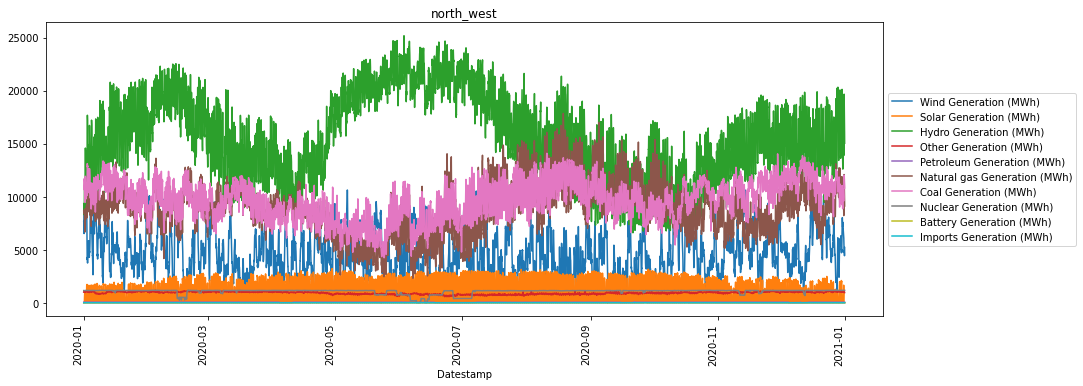

In [175]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole.plot(x="Datestamp", 
             y=np.array(column_list_Mwh),
             title = region,
             ax = ax )
plt.xticks(rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Annual Carbon Graph

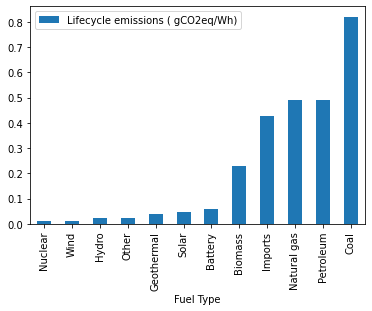

In [176]:
df_carbon = pd.read_csv("/content/drive/MyDrive/power/dataset/lcoe-co2/US Utility grids - LCOE, Co2 Emissions - Carbon4.csv")
df_carbon.sort_values('Lifecycle emissions ( gCO2eq/Wh)',ascending=True).plot( x='Fuel Type',y=["Lifecycle emissions ( gCO2eq/Wh)"],kind='bar')

Percentage fuel consumption from EIA fuel fix per hour

In [177]:
dfwhole["Wind Generation (%)"]= dfwhole["Wind Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Solar Generation (%)"]= dfwhole["Solar Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Hydro Generation (%)"]= dfwhole["Hydro Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Other Generation (%)"]= dfwhole["Other Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Petroleum Generation (%)"]= dfwhole["Petroleum Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Natural gas Generation (%)"]= dfwhole["Natural gas Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Coal Generation (%)"]= dfwhole["Coal Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Nuclear Generation (%)"]= dfwhole["Nuclear Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Battery Generation (%)"]= dfwhole["Battery Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 
dfwhole["Imports Generation (%)"]= dfwhole["Imports Generation (MWh)"]*100 / dfwhole["total Generation (MWh)"] 

dfwhole.columns
# dfnw.describe()

Index(['Region Code', 'Timestamp (Hour Ending)', 'Wind Generation (MWh)',
       'Solar Generation (MWh)', 'Hydro Generation (MWh)',
       'Other Generation (MWh)', 'Petroleum Generation (MWh)',
       'Natural gas Generation (MWh)', 'Coal Generation (MWh)',
       'Nuclear Generation (MWh)', 'Timestamp', 'Battery Generation (MWh)',
       'Imports Generation (MWh)', 'total Generation (MWh)', 'DATE', 'TIME',
       'Datestamp', 'Wind Generation (%)', 'Solar Generation (%)',
       'Hydro Generation (%)', 'Other Generation (%)',
       'Petroleum Generation (%)', 'Natural gas Generation (%)',
       'Coal Generation (%)', 'Nuclear Generation (%)',
       'Battery Generation (%)', 'Imports Generation (%)'],
      dtype='object')

 ## Graphs for percentage fuel mix 

Text(0, 0.5, 'Fuel Mix (%)')

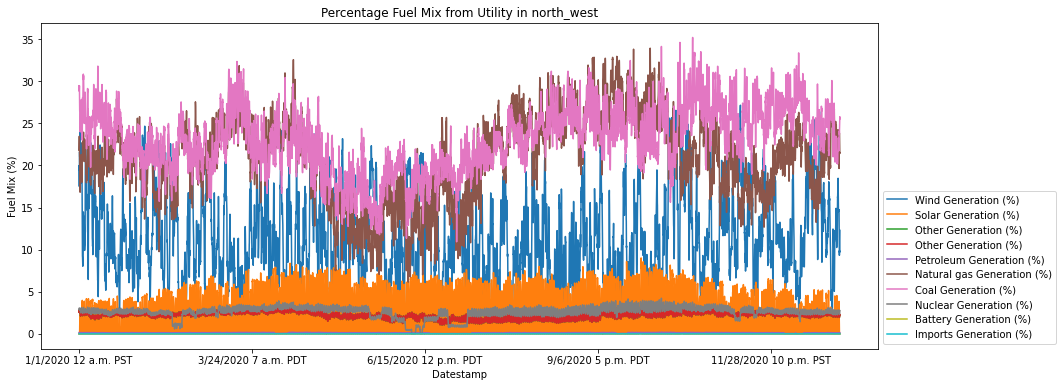

In [178]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole.plot(
      x= "Timestamp (Hour Ending)",
      y=["Wind Generation (%)",
      "Solar Generation (%)" , 
      "Other Generation (%)" ,
      "Other Generation (%)" , 
      "Petroleum Generation (%)", 
      "Natural gas Generation (%)", 
      "Coal Generation (%)", 
      "Nuclear Generation (%)",
      "Battery Generation (%)",
      "Imports Generation (%)"],
        title = "Percentage Fuel Mix from Utility in " + region ,
      ax=ax)
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Datestamp")
ax.set_ylabel("Fuel Mix (%)")

## Carbon Emission from power by utility generation

In [179]:
def df_calculate_carbon(df, columnlist): 
  for col in df[np.array(columnlist)].columns:
    # print(df[col])
    for j,carbon in df_carbon.iterrows():
      if carbon[0] in col:
          print("Match between two tables for "+col+ " and "+ carbon[0] +" - "+ str(carbon[1]))
          df['carbon_'+col.replace(" Generation (MWh)","(kgeCO2)")] = df[col] * carbon[1]# kg/MWh
  df["carbon_total(kgeCO2)"] = df[np.array(column_list_carbon)].sum(axis=1)

In [180]:
df_calculate_carbon(dfwhole, column_list_Mwh)
dfwhole.columns

Match between two tables for Wind Generation (MWh) and Wind - 12
Match between two tables for Solar Generation (MWh) and Solar - 48
Match between two tables for Hydro Generation (MWh) and Hydro - 24
Match between two tables for Other Generation (MWh) and Other - 24
Match between two tables for Petroleum Generation (MWh) and Petroleum - 490
Match between two tables for Natural gas Generation (MWh) and Natural gas - 490
Match between two tables for Coal Generation (MWh) and Coal - 820
Match between two tables for Nuclear Generation (MWh) and Nuclear - 12
Match between two tables for Battery Generation (MWh) and Battery - 59
Match between two tables for Imports Generation (MWh) and Imports - 428


Index(['Region Code', 'Timestamp (Hour Ending)', 'Wind Generation (MWh)',
       'Solar Generation (MWh)', 'Hydro Generation (MWh)',
       'Other Generation (MWh)', 'Petroleum Generation (MWh)',
       'Natural gas Generation (MWh)', 'Coal Generation (MWh)',
       'Nuclear Generation (MWh)', 'Timestamp', 'Battery Generation (MWh)',
       'Imports Generation (MWh)', 'total Generation (MWh)', 'DATE', 'TIME',
       'Datestamp', 'Wind Generation (%)', 'Solar Generation (%)',
       'Hydro Generation (%)', 'Other Generation (%)',
       'Petroleum Generation (%)', 'Natural gas Generation (%)',
       'Coal Generation (%)', 'Nuclear Generation (%)',
       'Battery Generation (%)', 'Imports Generation (%)',
       'carbon_Wind(kgeCO2)', 'carbon_Solar(kgeCO2)', 'carbon_Hydro(kgeCO2)',
       'carbon_Other(kgeCO2)', 'carbon_Petroleum(kgeCO2)',
       'carbon_Natural gas(kgeCO2)', 'carbon_Coal(kgeCO2)',
       'carbon_Nuclear(kgeCO2)', 'carbon_Battery(kgeCO2)',
       'carbon_Imports(kgeCO2

Text(0, 0.5, 'Carbon Emission from Power Demand (kgeCO2)')

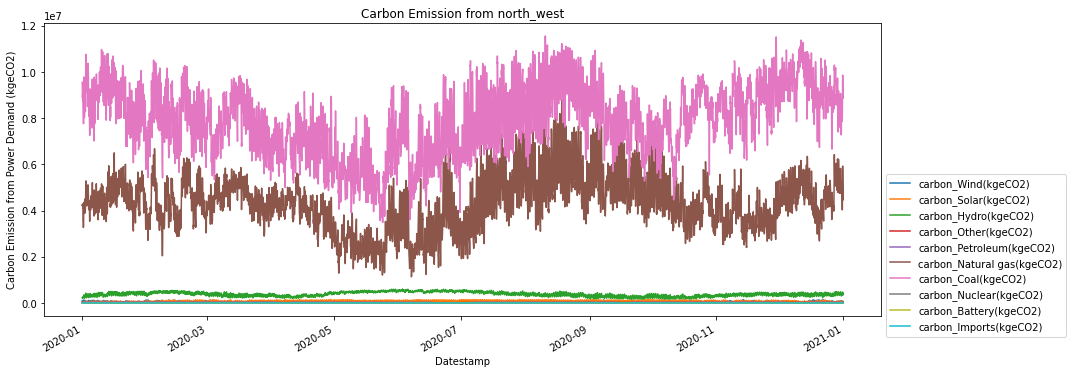

In [181]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole.plot( 
    x = "Datestamp",
    y = np.array(column_list_carbon),
    title = "Carbon Emission from "+ region,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xlabel("Datestamp")
ax.set_ylabel("Carbon Emission from Power Demand (kgeCO2)")

# Monthly

In [182]:
months_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

In [183]:
dfwhole.head()

,Region Code,Timestamp (Hour Ending),Wind Generation (MWh),Solar Generation (MWh),Hydro Generation (MWh),Other Generation (MWh),Petroleum Generation (MWh),Natural gas Generation (MWh),Coal Generation (MWh),Nuclear Generation (MWh),Timestamp,Battery Generation (MWh),Imports Generation (MWh),total Generation (MWh),DATE,TIME,Datestamp,Wind Generation (%),Solar Generation (%),Hydro Generation (%),Other Generation (%),Petroleum Generation (%),Natural gas Generation (%),Coal Generation (%),Nuclear Generation (%),Battery Generation (%),Imports Generation (%),carbon_Wind(kgeCO2),carbon_Solar(kgeCO2),carbon_Hydro(kgeCO2),carbon_Other(kgeCO2),carbon_Petroleum(kgeCO2),carbon_Natural gas(kgeCO2),carbon_Coal(kgeCO2),carbon_Nuclear(kgeCO2),carbon_Battery(kgeCO2),carbon_Imports(kgeCO2),carbon_total(kgeCO2)
0,NW,1/1/2020 12 a.m. PST,7689,-1,9348,1013,60,8627,11650,1150,1/1/2020 12 a.m. PST,0,0,39536,2020-01-01,00:00:00,2020-01-01 00:00:00,19.448098,-0.002529,23.644274,2.562222,0.151760,21.820619,29.466815,2.908741,0.0,0.0,92268,-48,224352,24312,29400,4227230,9553000,13800,0,0,14164314
1,NW,1/1/2020 1 a.m. PST,7751,-2,8920,1045,60,8576,11273,1152,1/1/2020 1 a.m. PST,0,0,38775,2020-01-01,01:00:00,2020-01-01 01:00:00,19.989684,-0.005158,23.004513,2.695035,0.154739,22.117344,29.072856,2.970986,0.0,0.0,93012,-96,214080,25080,29400,4202240,9243860,13824,0,0,13821400
2,NW,1/1/2020 2 a.m. PST,7269,1,8590,1063,59,8618,11142,1152,1/1/2020 2 a.m. PST,0,0,37894,2020-01-01,02:00:00,2020-01-01 02:00:00,19.182456,0.002639,22.668496,2.805193,0.155697,22.742387,29.403072,3.040059,0.0,0.0,87228,48,206160,25512,28910,4222820,9136440,13824,0,0,13720942
3,NW,1/1/2020 3 a.m. PST,6892,0,8941,1047,60,8627,10815,1149,1/1/2020 3 a.m. PST,0,0,37531,2020-01-01,03:00:00,2020-01-01 03:00:00,18.363486,0.000000,23.822973,2.789694,0.159868,22.986331,28.816179,3.061469,0.0,0.0,82704,0,214584,25128,29400,4227230,8868300,13788,0,0,13461134
4,NW,1/1/2020 4 a.m. PST,6526,-1,8779,1043,59,8748,10973,1147,1/1/2020 4 a.m. PST,0,0,37274,2020-01-01,04:00:00,2020-01-01 04:00:00,17.508183,-0.002683,23.552610,2.798197,0.158287,23.469443,29.438751,3.077212,0.0,0.0,78312,-48,210696,25032,28910,4286520,8997860,13764,0,0,13641046


In [184]:

# temp["DATETIME"]= pd.to_datetime(temp['DATE'] + ' ' + temp['TIME'])
# temp = temp.set_index('DATETIME')

# days = dfwhole["DATE"].unique()

In [185]:
dfwhole_months = dfwhole.resample('M',on='Datestamp').agg({'Wind Generation (MWh)':'sum', 
                                        'Solar Generation (MWh)':'sum',
                                        'Hydro Generation (MWh)':'sum', 
                                        'Other Generation (MWh)':'sum', 
                                        'Petroleum Generation (MWh)':'sum', 
                                        'Natural gas Generation (MWh)':'sum',
                                        'Coal Generation (MWh)':'sum',
                                        'Nuclear Generation (MWh)':'sum',
                                        'Battery Generation (MWh)':'sum',
                                        'Imports Generation (MWh)':'sum',
                                        'total Generation (MWh)':'sum',
                                        'DATE':'unique'})
dfwhole_months.head(5)

,Wind Generation (MWh),Solar Generation (MWh),Hydro Generation (MWh),Other Generation (MWh),Petroleum Generation (MWh),Natural gas Generation (MWh),Coal Generation (MWh),Nuclear Generation (MWh),Battery Generation (MWh),Imports Generation (MWh),total Generation (MWh),DATE
Datestamp,,,,,,,,,,,,
2020-01-31,3982866,363916,11820111,750064,43907,6953811,7983756,861437,0,0,32759868,"[2020-01-01, 2020-01-02, 2020-01-03, 2020-01-0..."
2020-02-29,3801528,516516,12810276,709150,41404,6237804,6825014,726765,0,0,31668457,"[2020-02-01, 2020-02-02, 2020-02-03, 2020-02-0..."
2020-03-31,3309269,615151,10249841,767130,44095,6947685,7021110,855103,0,0,29809384,"[2020-03-01, 2020-03-02, 2020-03-03, 2020-03-0..."
2020-04-30,3162655,773987,9469679,694711,36683,5979872,5914257,836394,0,0,26868238,"[2020-04-01, 2020-04-02, 2020-04-03, 2020-04-0..."
2020-05-31,3362437,853610,15082021,607822,39974,4001719,5124304,790064,0,0,29861951,"[2020-05-01, 2020-05-02, 2020-05-03, 2020-05-0..."


 ## Energy consumption by month ( bar chart)

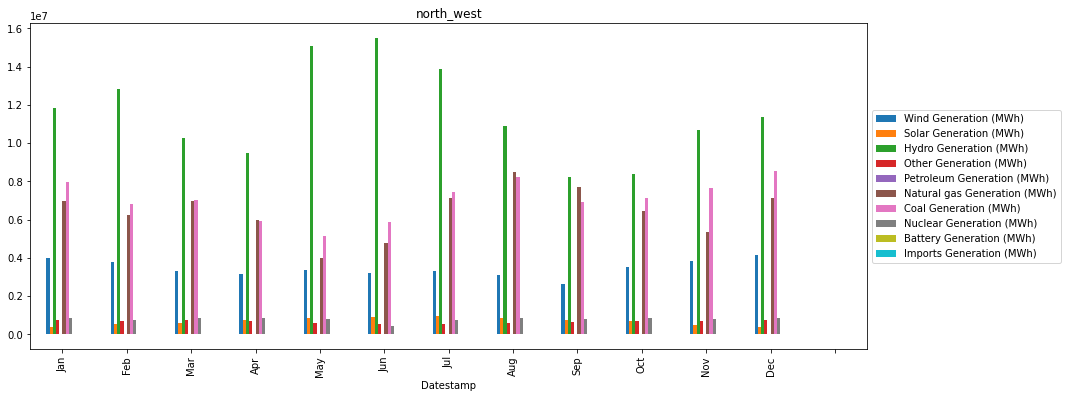

In [186]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)

dfwhole_months.plot.bar( 
             y=np.array(column_list_Mwh),
             title = region,
             ax = ax )
ax.set_xticklabels(months_list)
plt.xticks(rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Fuel Mix % ( pie chart )

In [187]:
dfwhole_months.iloc[0]
# column_list_Mwh

Wind Generation (MWh)                                                     3982866
Solar Generation (MWh)                                                     363916
Hydro Generation (MWh)                                                   11820111
Other Generation (MWh)                                                     750064
Petroleum Generation (MWh)                                                  43907
Natural gas Generation (MWh)                                              6953811
Coal Generation (MWh)                                                     7983756
Nuclear Generation (MWh)                                                   861437
Battery Generation (MWh)                                                        0
Imports Generation (MWh)                                                        0
total Generation (MWh)                                                   32759868
DATE                            [2020-01-01, 2020-01-02, 2020-01-03, 2020-01-0...
Name: 2020-01-31

Wind Generation (MWh)                                                     3982866
Solar Generation (MWh)                                                     363916
Hydro Generation (MWh)                                                   11820111
Other Generation (MWh)                                                     750064
Petroleum Generation (MWh)                                                  43907
Natural gas Generation (MWh)                                              6953811
Coal Generation (MWh)                                                     7983756
Nuclear Generation (MWh)                                                   861437
Battery Generation (MWh)                                                        0
Imports Generation (MWh)                                                        0
total Generation (MWh)                                                   32759868
DATE                            [2020-01-01, 2020-01-02, 2020-01-03, 2020-01-0...
Name: 2020-01-31

ValueError: ignored

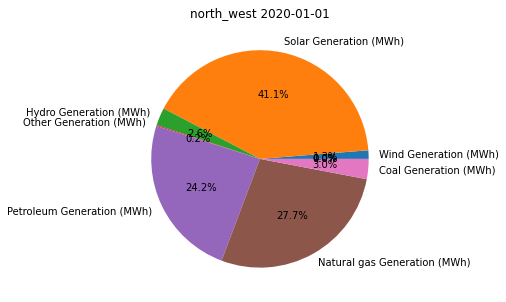

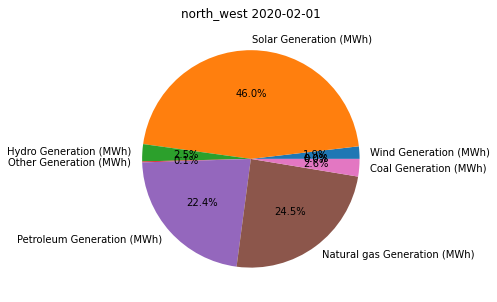

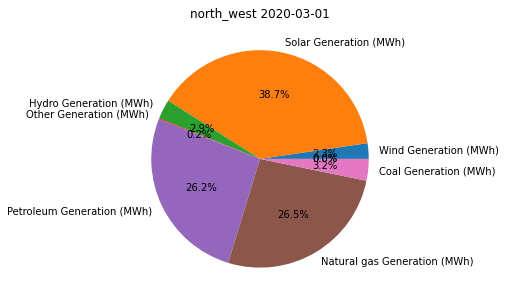

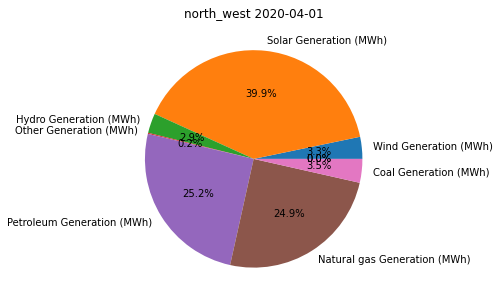

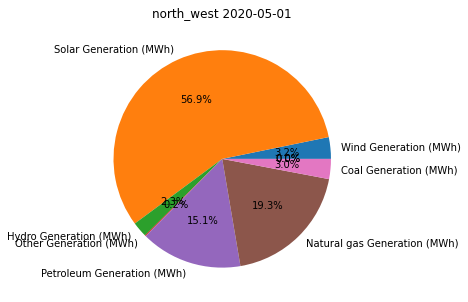

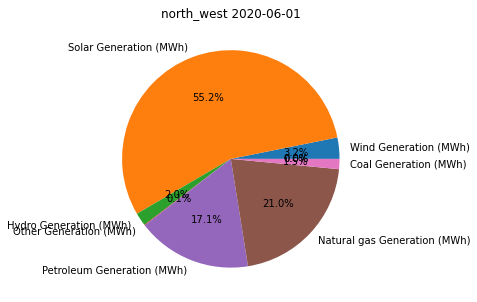

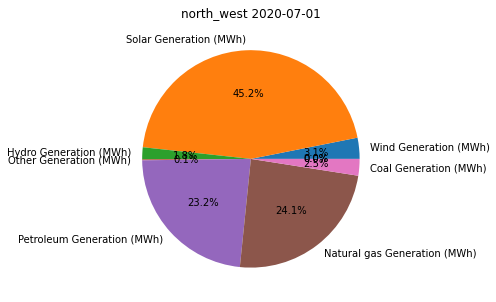

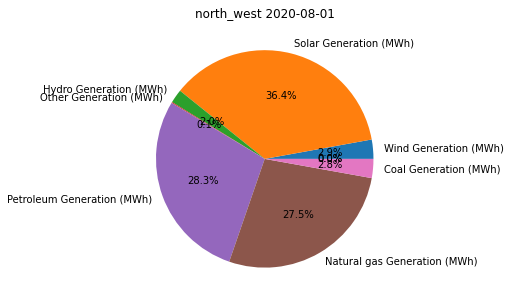

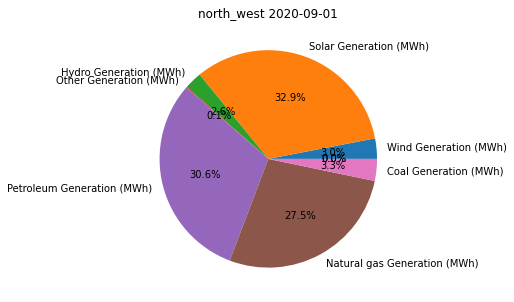

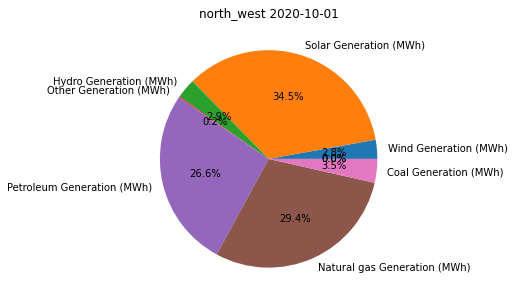

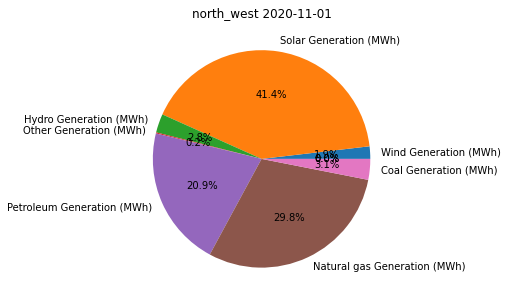

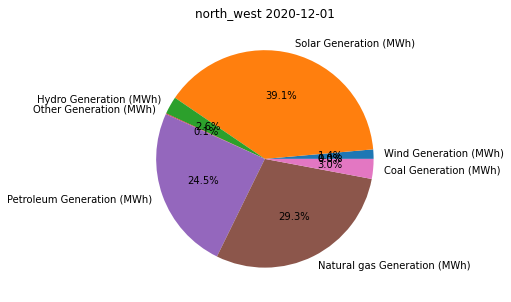

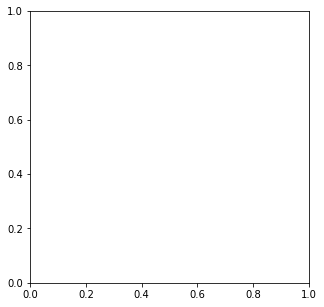

In [188]:
## Fuel Mix by month pie chart

for i,row in dfwhole_months.iterrows():
   fig, ax = plt.subplots(1,1)
   fig.set_size_inches(5,5)
  #  row=row[1:7]
   print(row)
   row.iloc[1:10].plot(kind='pie', 
                       title = region+" "+ str(row.iloc[11][0]) ,
                       y=np.array(column_list_Mwh),labels=np.array(column_list_Mwh),
                       ax=ax, autopct='%1.1f%%')
   ax.set_ylabel('')
   ax.set_xlabel('')


# fig, ax = plt.subplots()
# fig.set_size_inches(15, 6)

# # dfwhole_months = dfwhole_months.reset_index(drop=True)
# pie = dfwhole_months.iloc[0].plot.pie( 
#             # x="Timestamp",
#             #  y=np.array(column_list_Mwh),index=np.array(column_list_Mwh),
#             labels=np.array(column_list_Mwh),
#              title = region,
#              autopct='%1.1f%%', 
#              explode=(0.1, 0.1, 0.1 ,0.1,0.1,0.1,0.1,0.2), # explode=None 
#              shadow=True, startangle=0,
#              figsize=(5, 5))

# pie.legend(bbox_to_anchor=(1.5,1),
#             labels = column_list, 
#             loc="bottom right")

In [ ]:
## Total Generation Bar chart

fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole_months.plot.bar(
             y= "total Generation (MWh)",
             title = region,
             ax = ax )
ax.set_xticklabels(months_list)
plt.xticks(rotation=90)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Carbon emission by month ( bar chart ) 

In [ ]:
dfwhole_months_carbon = dfwhole.resample('M',on='Datestamp').agg({'carbon_Wind(kgeCO2)':'sum', 
                                        'carbon_Solar(kgeCO2)':'sum',
                                        'carbon_Hydro(kgeCO2)':'sum', 
                                        'carbon_Other(kgeCO2)':'sum', 
                                        'carbon_Petroleum(kgeCO2)':'sum', 
                                        'carbon_Natural gas(kgeCO2)':'sum',
                                        'carbon_Coal(kgeCO2)':'sum',
                                        'carbon_Nuclear(kgeCO2)':'sum',
                                        'carbon_Battery(kgeCO2)':'sum',
                                        'carbon_Imports(kgeCO2)':'sum',
                                        'carbon_total(kgeCO2)':'sum',
                                        'DATE':'unique'})
dfwhole_months_carbon.head()

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole_months_carbon.plot.bar( 
    # x = "Datestamp",
    y = np.array(column_list_carbon),
    title = "Carbon Emission from "+ region,
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticklabels(months_list)
ax.set_xlabel("Datestamp")
ax.set_ylabel("Carbon Emission from Power Demand (kgeCO2)")

In [ ]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 6)
dfwhole_months_carbon.plot.bar( 
    # x = "Datestamp",
    y = ["carbon_total(kgeCO2)"],
    title = "Carbon Emission from "+ region,
    color="red",
    ax=ax) 
ax.legend(loc='bottom left', bbox_to_anchor=(1.0, 0.5))
ax.set_xticklabels(months_list)
ax.set_xlabel("Datestamp")
ax.set_ylabel("Carbon Emission from Power Demand (kgeCO2)")

#  Daily hourly fluctuation throughout the year 

In [ ]:
# fig, ax = plt.subplots()
# fig.set_size_inches(15, 6)
# dfwhole_months.plot( x="HOUR",
#              y=np.array(column_list_Mwh),
#              title = region,
#              ax = ax )
# plt.xticks(rotation=90)
# ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [ ]:
df_carbondiff.to_csv(region+"_carbondiff.csv",index=True, header=True)